<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Long_Term_Reprojection_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Code:

In [1]:
!git clone https://github.com/mobarakol/LTRL_DEV.git
%cd LTRL_DEV

Cloning into 'LTRL_DEV'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 87 (delta 31), reused 72 (delta 24), pack-reused 0
Receiving objects: 100% (87/87), 798.33 KiB | 16.99 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/LTRL_DEV


Download Dataset and Weights:

In [2]:
import gdown

d3k4_url = 'https://drive.google.com/uc?id=1_HrQTeZgU3AE88p1Ykawi2lkdijRNQVz'
gdown.download(d3k4_url,'d3k4.zip',quiet=True)
!unzip -q d3k4.zip
!mkdir 02
!mv -f d3k4 02/

d3k4_url = 'https://drive.google.com/uc?id=1B_auq0oUoXuk_YfoidE0B90YGazoVm2Y'
gdown.download(d3k4_url,'weights_19.zip',quiet=True)
!unzip -q weights_19.zip

Pose Estimation for Seq 02 d3k4:

In [2]:
%cd /content/LTRL_DEV
!python evaluate_pose.py --data_path '' --eval_split endovis --load_weights_folder weights_19 --batch_size 8

/content/LTRL_DEV
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
total samples:  833
batch size:  8
number of batch / epoch:  105
-> Computing pose predictions

   Trajectory error: 0.0512, std: 0.0294


   Rotation error: 0.0032, std: 0.0020



Pose trajectory visualization:

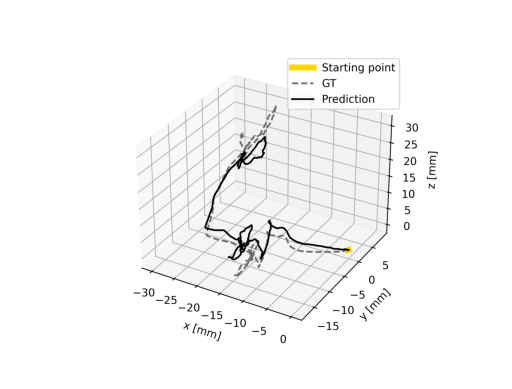

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

img  = Image.open('vo_sq2_19.png')
plt.axis('OFF')
plt.imshow(img)

Depth for a sample frame:

Text(0.5, 1.0, 'Depth Prediction')

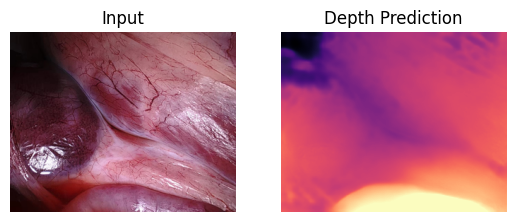

In [7]:
import datasets
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt

import networks
from layers import disp_to_depth


scared_dataset = datasets.SCAREDRAWDataset
with open("splits/endovis/test_files_sequence2.txt", 'r') as f:
    filenames = f.read().splitlines()

img_ext = '.jpg'
data_path = ""
height = 256
width = 320
frame_ids = [-2, -1, 0, 1, 2]
num_samples = len(filenames)

sample_dataset = scared_dataset(data_path, filenames, height, width,
    frame_ids, 4, is_train=False, img_ext=img_ext)
loader = DataLoader(
    sample_dataset, 8, True, pin_memory=True, drop_last=True)

inputs = next(enumerate(loader))
sample = inputs[1][("color_aug", -2, 0)]

device = "cuda" if torch.cuda.is_available() else "cpu"

encoder_path = "weights_19/encoder.pth"
decoder_path = "weights_19/depth.pth"
encoder_dict = torch.load(encoder_path, map_location=device)
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(encoder.num_ch_enc, scales=range(4))

model_dict = encoder.state_dict()
encoder.load_state_dict({k: v for k, v in encoder_dict.items() if k in model_dict})
depth_decoder.load_state_dict(torch.load(decoder_path, map_location=device))

encoder.to(device)
encoder.eval()
depth_decoder.to(device)
depth_decoder.eval()
sample = sample.to(device)

output = depth_decoder(encoder(sample))
pred_disp, _ = disp_to_depth(output[("disp", 0)], 1e-3, 150)
pred_disp = pred_disp.cpu()[:, 0].detach().numpy()
sample = sample.cpu()
vmax = np.percentile(pred_disp, 95)

plt.subplot(121), plt.imshow(sample[0].permute(1,2,0))
plt.axis('OFF')
plt.title('Input')

plt.subplot(122), plt.imshow(pred_disp[0], cmap='magma', vmax=vmax)
plt.axis('OFF')
plt.title('Depth Prediction')

3D Reconstruction for a sample frame from predicted depth and pose and GT depth and pose:

Depth Metrics as paper: